# ***※ 런타임 설정 GPU 확인 必.***

In [ ]:
!nvidia-smi

Sun Mar 16 09:40:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             52W /  400W |     429MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


# ***구글 드라이브 연결***

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/My Drive
!ls /mydrive

%pdb on

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link 'Drive': File exists
ls: cannot access '/mydrive': No such file or directory
Automatic pdb calling has been turned ON


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ***YOLO 환경 설치***

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 40.9/235.7 GB disk)


In [ ]:
import torch
import torch.amp as amp  # cuda.amp 대신 amp 사용
from torch.serialization import safe_globals
import os
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel
import gc


class ModelLightweight:
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.scaler = amp.GradScaler('cuda')  # 수정된 GradScaler 초기화

    def setup_cuda(self):
        """A100 GPU 최적화 설정"""
        if torch.cuda.is_available():
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.benchmark = True
            torch.backends.cudnn.deterministic = False
            torch.backends.cudnn.allow_tf32 = True

            torch.cuda.empty_cache()
            gc.collect()

            print(f"CUDA 설정 완료: {torch.cuda.get_device_name()}")
            print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    def load_model(self):
        try:
            self.setup_cuda()

            with safe_globals([DetectionModel]):
                with amp.autocast('cuda'):  # 수정된 autocast 사용
                    self.model = torch.load(
                        self.model_path,
                        map_location=self.device,
                        weights_only=False
                    )
            print("모델 로드 성공")
            print(f"모델 타입: {type(self.model)}")  # 디버깅을 위한 모델 타입 출력
            return True
        except Exception as e:
            print(f"모델 로드 실패: {str(e)}")
            return False

    def apply_lightweight_modifications(self):
        try:
            with amp.autocast('cuda'):
                # 모델 구조에 따른 처리
                if isinstance(self.model, dict):
                    model_dict = self.model
                elif hasattr(self.model, 'model') and hasattr(self.model.model, 'state_dict'):
                    model_dict = self.model.model.state_dict()
                elif hasattr(self.model, 'state_dict'):
                    model_dict = self.model.state_dict()
                else:
                    print("지원되지 않는 모델 형식입니다.")
                    print(f"모델 타입: {type(self.model)}")
                    return False

                new_state_dict = {}

                for key, value in model_dict.items():
                    if isinstance(value, torch.Tensor):
                        # 텐서를 GPU로 이동
                        value = value.to(self.device)

                        # 가중치 프루닝
                        if 'weight' in key:
                            threshold = 1e-2
                            mask = torch.abs(value) > threshold
                            value = value * mask

                        # Mixed Precision을 위한 FP16 변환
                        value = value.half()

                    new_state_dict[key] = value

                self.model = new_state_dict
                print("경량화 수정 완료")
                return True

        except Exception as e:
            print(f"경량화 수정 중 에러 발생: {str(e)}")
            print(f"모델 구조: {type(self.model)}")  # 디버깅을 위한 모델 구조 출력
            return False

    def save_model(self, output_path):
        try:
            with amp.autocast('cuda'):
                torch.save(self.model, output_path)
            print(f"모델 저장 완료: {output_path}")
            return True
        except Exception as e:
            print(f"모델 저장 실패: {str(e)}")
            return False

def analyze_model_structure(model):
    """모델 구조 분석"""
    print("\n=== 모델 구조 분석 ===")
    if isinstance(model, dict):
        print("Dictionary 형태의 모델")
        for key in model.keys():
            print(f"키: {key}")
    elif hasattr(model, 'model'):
        print("내부 모델 구조 있음")
        print(model.model)
    else:
        print(f"모델 타입: {type(model)}")
        print(dir(model))

def verify_model(model_path, device):
    """모델 검증"""
    try:
        with safe_globals([DetectionModel]):
            with amp.autocast('cuda'):
                model = torch.load(model_path, map_location=device, weights_only=False)

        print(f"\n=== 모델 검증: {os.path.basename(model_path)} ===")
        analyze_model_structure(model)

        if torch.cuda.is_available():
            print(f"\nGPU 메모리 사용량: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU 메모리 캐시: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

        return True
    except Exception as e:
        print(f"모델 검증 실패: {str(e)}")
        return False

def main():
    print("YOLOv11n 모델 경량화 시작")

    # A100 GPU 설정 확인
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"CUDA 버전: {torch.version.cuda}")
        print(f"PyTorch 버전: {torch.__version__}")

    # 경로 설정
    model_path = '/content/gdrive/MyDrive/PouchCellDefectDetection/yolov11nbest.pt'
    output_path = '/content/yolov11n_lightweight.pt'

    # 모델 경량화
    lightweight = ModelLightweight(model_path)

    if not lightweight.load_model():
        return

    # 모델 구조 분석
    analyze_model_structure(lightweight.model)

    if not lightweight.apply_lightweight_modifications():
        return

    if not lightweight.save_model(output_path):
        return

    # 모델 크기 비교
    original_size = os.path.getsize(model_path) / (1024 * 1024)
    modified_size = os.path.getsize(output_path) / (1024 * 1024)

    print("\n=== 모델 경량화 결과 ===")
    print(f"원본 모델 크기: {original_size:.2f} MB")
    print(f"수정된 모델 크기: {modified_size:.2f} MB")
    print(f"크기 감소율: {((original_size - modified_size) / original_size * 100):.2f}%")

    # 검증
    print("\n원본 모델 검증")
    verify_model(model_path, device)

    print("\n경량화된 모델 검증")
    verify_model(output_path, device)

    # GPU 메모리 정리
    torch.cuda.empty_cache()
    gc.collect()

if __name__ == "__main__":
    print("\n=== YOLOv11n 모델 경량화 도구 (A100 최적화) ===")
    main()


=== YOLOv11n 모델 경량화 도구 (A100 최적화) ===
YOLOv11n 모델 경량화 시작
GPU: NVIDIA A100-SXM4-40GB
CUDA 버전: 12.4
PyTorch 버전: 2.6.0+cu124
CUDA 설정 완료: NVIDIA A100-SXM4-40GB
Available memory: 42.47 GB
모델 로드 성공
모델 타입: <class 'dict'>

=== 모델 구조 분석 ===
Dictionary 형태의 모델
키: date
키: version
키: license
키: docs
키: epoch
키: best_fitness
키: model
키: ema
키: updates
키: optimizer
키: train_args
키: train_metrics
키: train_results
경량화 수정 완료
모델 저장 완료: /content/yolov11n_lightweight.pt

=== 모델 경량화 결과 ===
원본 모델 크기: 5.23 MB
수정된 모델 크기: 5.26 MB
크기 감소율: -0.74%

원본 모델 검증

=== 모델 검증: yolov11nbest.pt ===

=== 모델 구조 분석 ===
Dictionary 형태의 모델
키: date
키: version
키: license
키: docs
키: epoch
키: best_fitness
키: model
키: ema
키: updates
키: optimizer
키: train_args
키: train_metrics
키: train_results

GPU 메모리 사용량: 0.01 GB
GPU 메모리 캐시: 0.01 GB

경량화된 모델 검증

=== 모델 검증: yolov11n_lightweight.pt ===

=== 모델 구조 분석 ===
Dictionary 형태의 모델
키: date
키: version
키: license
키: docs
키: epoch
키: best_fitness
키: model
키: ema
키: updates
키: optimizer
키: train_arg

V8 까지 공식 릴리즈 됨. v11은 공식 릴리즈 지원 안됨

# ***※ 실험 진행 시 폴더명 생성(Lot) 관리 철저히 할 것***

## **data set 준비**

# ※ Colab 경로에 "띄어쓰기" 못 읽음, 모든 경로 띄어쓰기 제외
★ 이미 구글 드라이브에 데이터 셋팅을 완료했기에, 주석처리를 함

추후 신규프로젝트 시작할때는 필수 요소임.

In [ ]:
#!mkdir "/content/gdrive/MyDrive/PouchCellDefectDetection/Dataset/"
#%cd /content/gdrive/MyDrive/PouchCellDefectDetection/DataSet

#!unzip /content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/DataSet.zip

In [ ]:
%cat /content/gdrive/MyDrive/PouchCellDefectDetection/data.yaml

names:
- Pass
- Leakage
- ''
- ''
- Pinhole
- Swelling
- Scratch
nc: 7
test: ../test/images
train: /content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/train.txt
val: /content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/val.txt


전체 이미지를 glob으로 긁어와서, img_list 로 정의함

Train / Val 용으로 데이터를 나누기 위함

In [ ]:
%cd /
from glob import glob

img_list = glob('/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/*.jpg')

print(len(img_list))

/
15312


Train = 12,249 장
Val = 3,063 으로 나뉨

Test_size = 0.2 setting 시 8:2 비율로 나눠짐

In [ ]:
from sklearn.model_selection import train_test_split

train_img_list, val_img_list = train_test_split(img_list, test_size=0.2, random_state=2000)

print(len(train_img_list), len(val_img_list))

12249 3063


Label Data 도 같이 분류 함

In [ ]:
with open('/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/train.txt', 'w') as f:
  f.write('\n'.join(train_img_list) + '\n')

with open('/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/val.txt', 'w') as f:
  f.write('\n'.join(val_img_list) + '\n')

yaml 경로에 수정 된 내용 반영

In [ ]:
import yaml

with open('/content/gdrive/MyDrive/PouchCellDefectDetection/data.yaml', 'r') as f:
    data = yaml.safe_load(f)

print(data)

data['train'] = '/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/train.txt'
data['val'] = '/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/val.txt'

with open('/content/gdrive/MyDrive/PouchCellDefectDetection/data.yaml', 'w') as f:
  yaml.dump(data, f)

print(data)

{'names': ['Pass', 'Leakage', '', '', 'Pinhole', 'Swelling', 'Scratch'], 'nc': 7, 'test': '../test/images', 'train': '/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/train.txt', 'val': '/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/val.txt'}
{'names': ['Pass', 'Leakage', '', '', 'Pinhole', 'Swelling', 'Scratch'], 'nc': 7, 'test': '../test/images', 'train': '/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/train.txt', 'val': '/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet/val.txt'}


# ***Comet 연동 확인 必.***

Project Name 철저한 관리로 실험 결과 체계적 관리 必.

workspace는 PJ 단위 별로 수정 예정

In [ ]:

#@title 데이터 연동 확인 必. {run: 'auto'}
logger = 'Comet' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
    %pip install -q comet_ml
    import os
    import comet_ml

    # API 키 자동 설정
    os.environ["COMET_API_KEY"] = "5dKvyBL4M1AqGE13J5zeJHVFb"

    try:
        # Comet ML 초기화
        comet_ml.init(
            api_key=os.environ["COMET_API_KEY"],
            project_name="250303_N_Test1",  # 프로젝트 이름 설정
            workspace="battery"  # 작업공간 설정
        )
        print("Comet ML이 성공적으로 초기화되었습니다.")

    except Exception as e:
        print(f"Comet ML 초기화 중 오류 발생: {str(e)}")

elif logger == 'TensorBoard':
    %load_ext tensorboard
    %tensorboard --logdir .
    print("TensorBoard가 성공적으로 로드되었습니다.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.8/725.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 98.1 MB/s eta 0:00:00


COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()
COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


Comet ML이 성공적으로 초기화되었습니다.


In [ ]:
# !pip install comet_ml

# import comet_ml
# import os
# from comet_ml import Experiment

# # Comet 실험 설정
# experiment = Experiment(
#     api_key="5dKvyBL4M1AqGE13J5zeJHVFb", #API KEY
#     project_name="250303_N_Test1(Success/Failed)", #실험날짜_모델(N,S,M,L,X)_실험 횟수(실험 결과 간략표기)
#     workspace="battery"
# )

※ 실험 접근 방법

### **1. 기본 필수 설정**
task=detect              # detect, segment, classify, track, pose, OBB 중 선택 / *OBB ?*

mode=train              # train, val, predict 중 선택

model=yolov11s.pt       # 사용할 모델 지정

## ***★ model 은 yolo11n.pt 양식으로 , 11n, 11s, 11m, 11l, 11x 가 있음***
### **2. 데이터 관련 설정**
data=/path/data.yaml    # 데이터 설정 파일 경로

imgsz=640              # 입력 이미지 크기 (320, 416, 512, 640 등)

batch=16               # 배치 크기

workers=8              # 데이터 로딩 워커 수
### **3. 학습 관련 설정**
epochs=100             # 학습 에포크 수

patience=50            # early stopping patience

lr0=0.01              # 초기 학습률

lrf=0.01              # 최종 학습률

momentum=0.937        # SGD 모멘텀

weight_decay=0.0005   # 가중치 감쇠
### **4. 시각화 및 저장 관련 설정**
plots=True            # 학습 그래프 저장 여부

save=True            # 모델 저장 여부

save_period=1        # 모델 저장 주기

device=0             # GPU 장치 선택 (0, 1, cpu)
### **5. 사용 예시**
!yolo task=detect \
      mode=train \
      model=yolov11s.pt \
      data=/content/data.yaml \
      epochs=100 \
      imgsz=640 \
      batch=16 \
      patience=50 \
      lr0=0.01 \
      plots=True \
      save_period=10

# **※ Training**

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=/content/yolov11n_lightweight.pt data=/content/gdrive/MyDrive/PouchCellDefectDetection/data.yaml epochs=100 imgsz=640 plots=True

/content
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov11n_lightweight.pt, data=/content/gdrive/MyDrive/PouchCellDefectDetection/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, s

In [ ]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		  val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		  val_batch0_pred.jpg
confusion_matrix.png				    results.png		  val_batch1_labels.jpg
events.out.tfevents.1742118060.984ebc804ab9.6025.0  train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	  val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2.jpg	  val_batch2_pred.jpg
labels.jpg					    train_batch68940.jpg  weights
P_curve.png					    train_batch68941.jpg
PR_curve.png					    train_batch68942.jpg


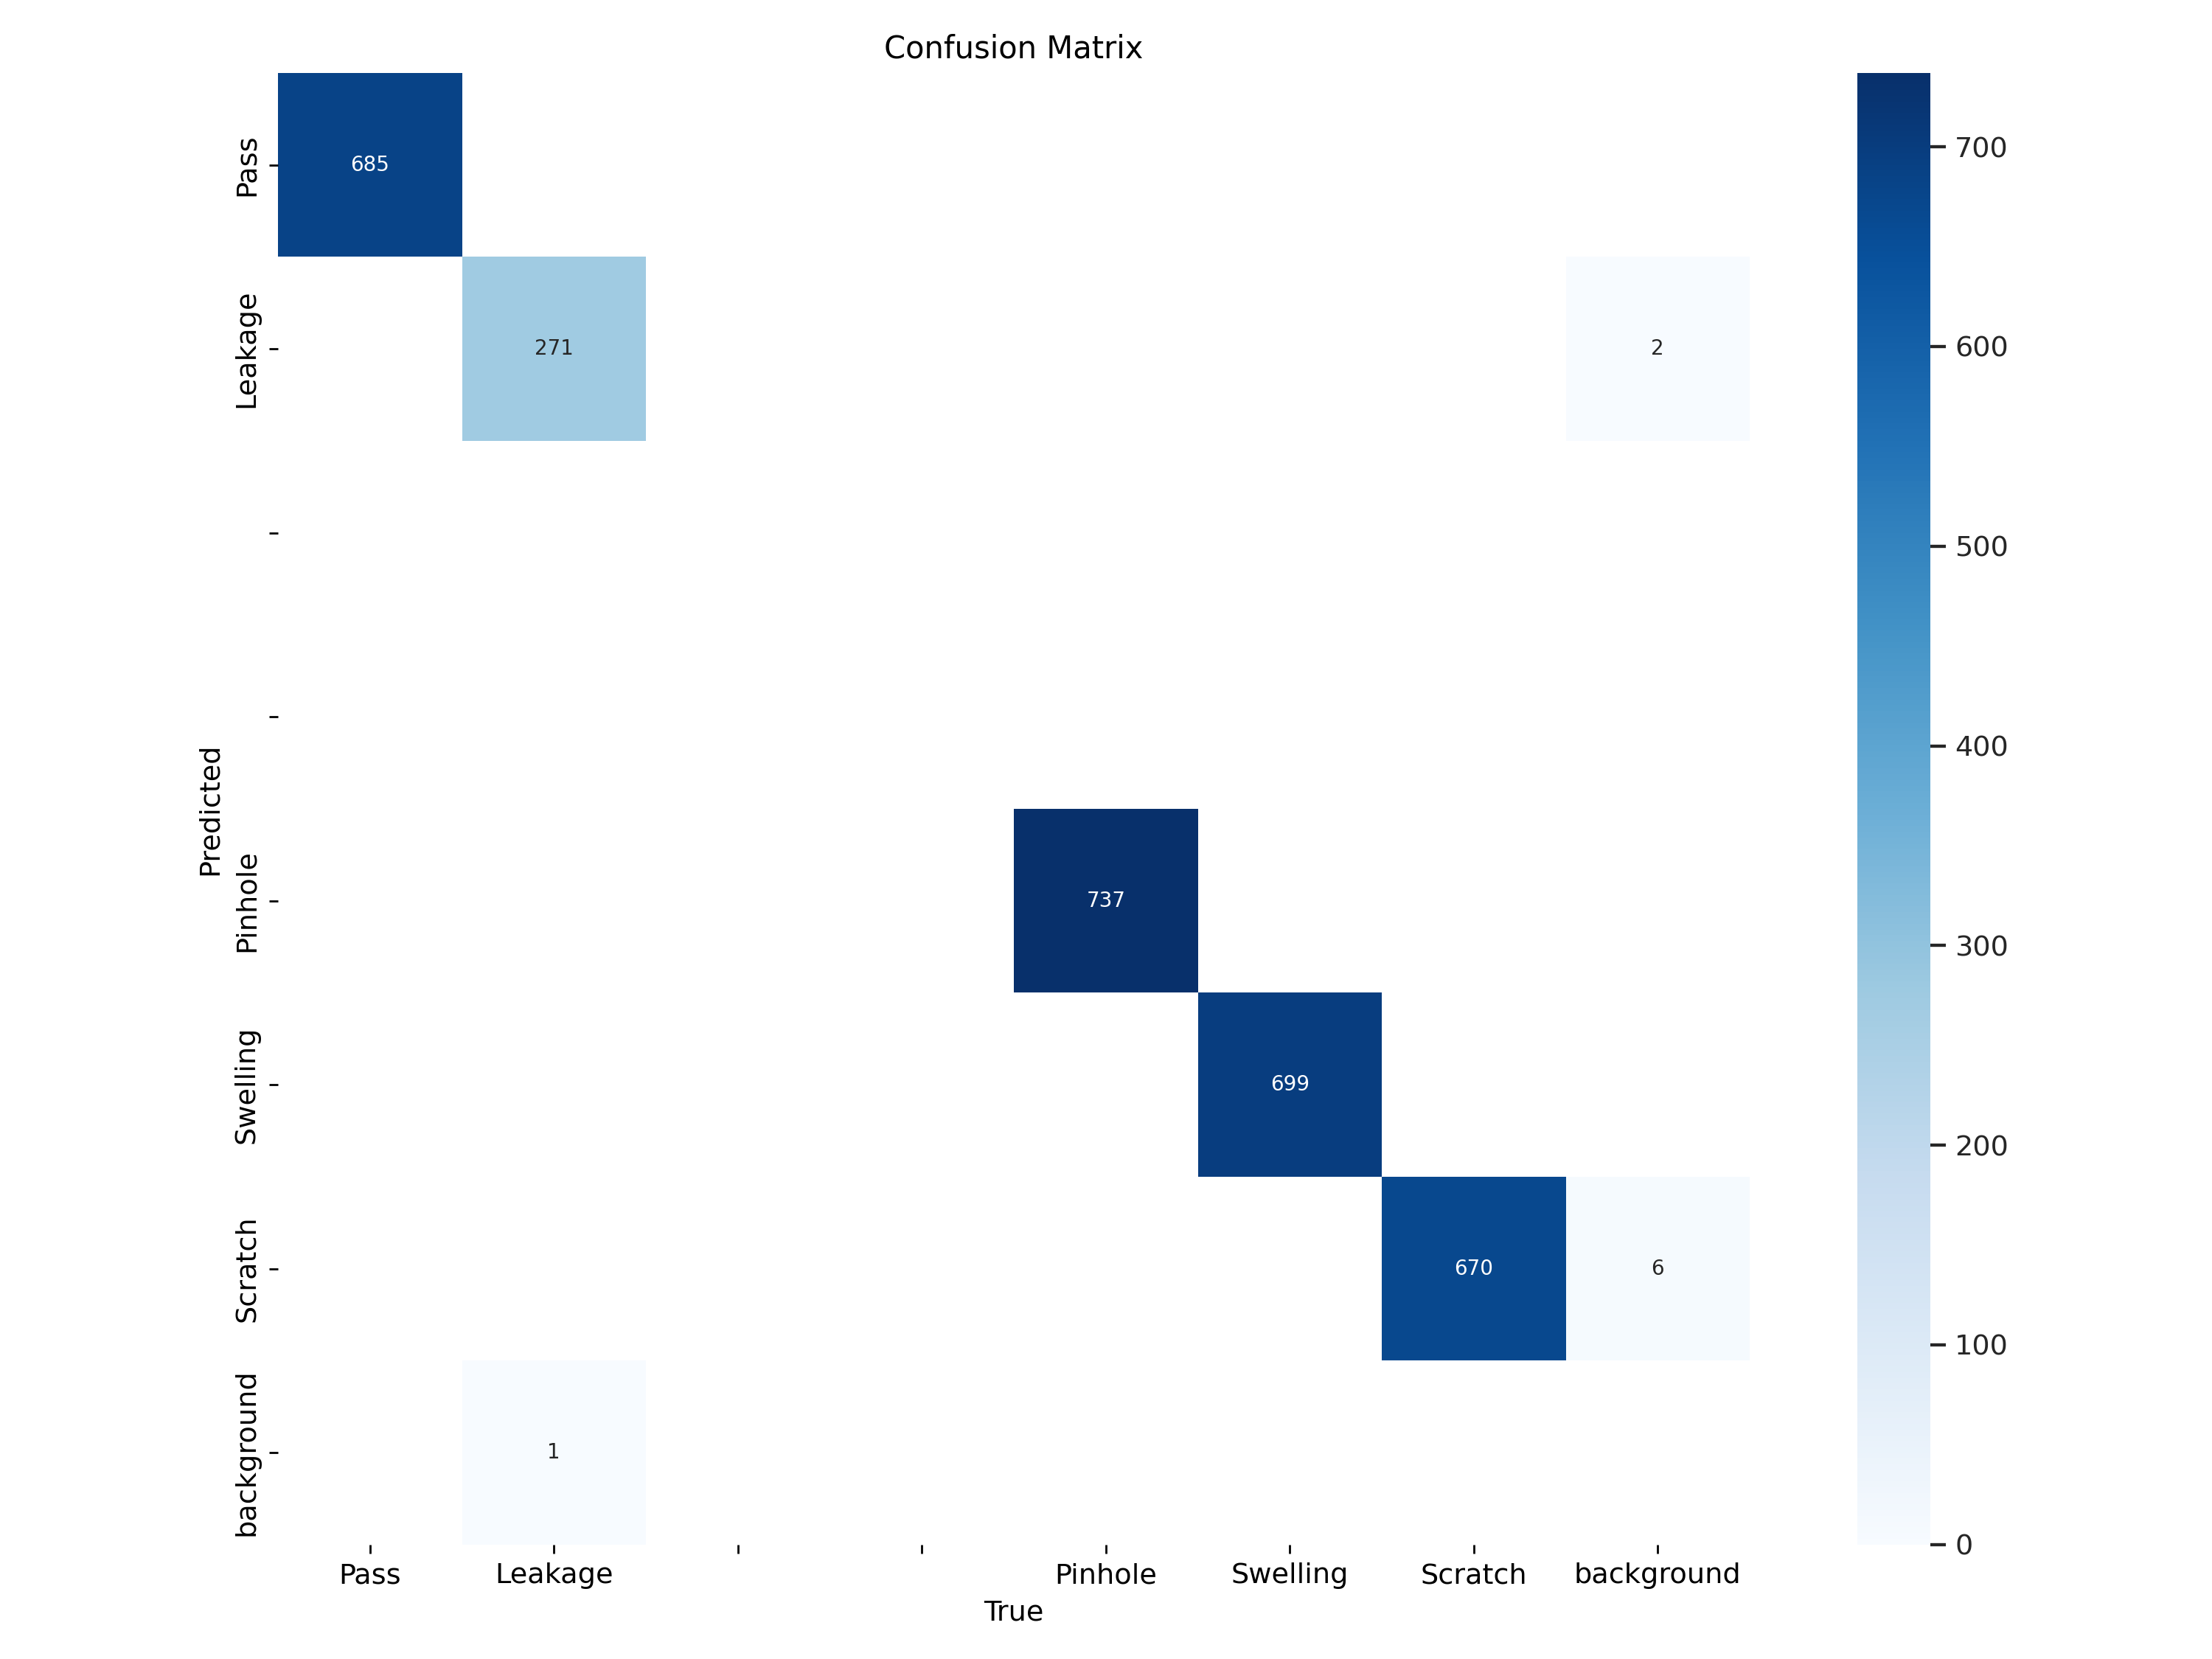

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

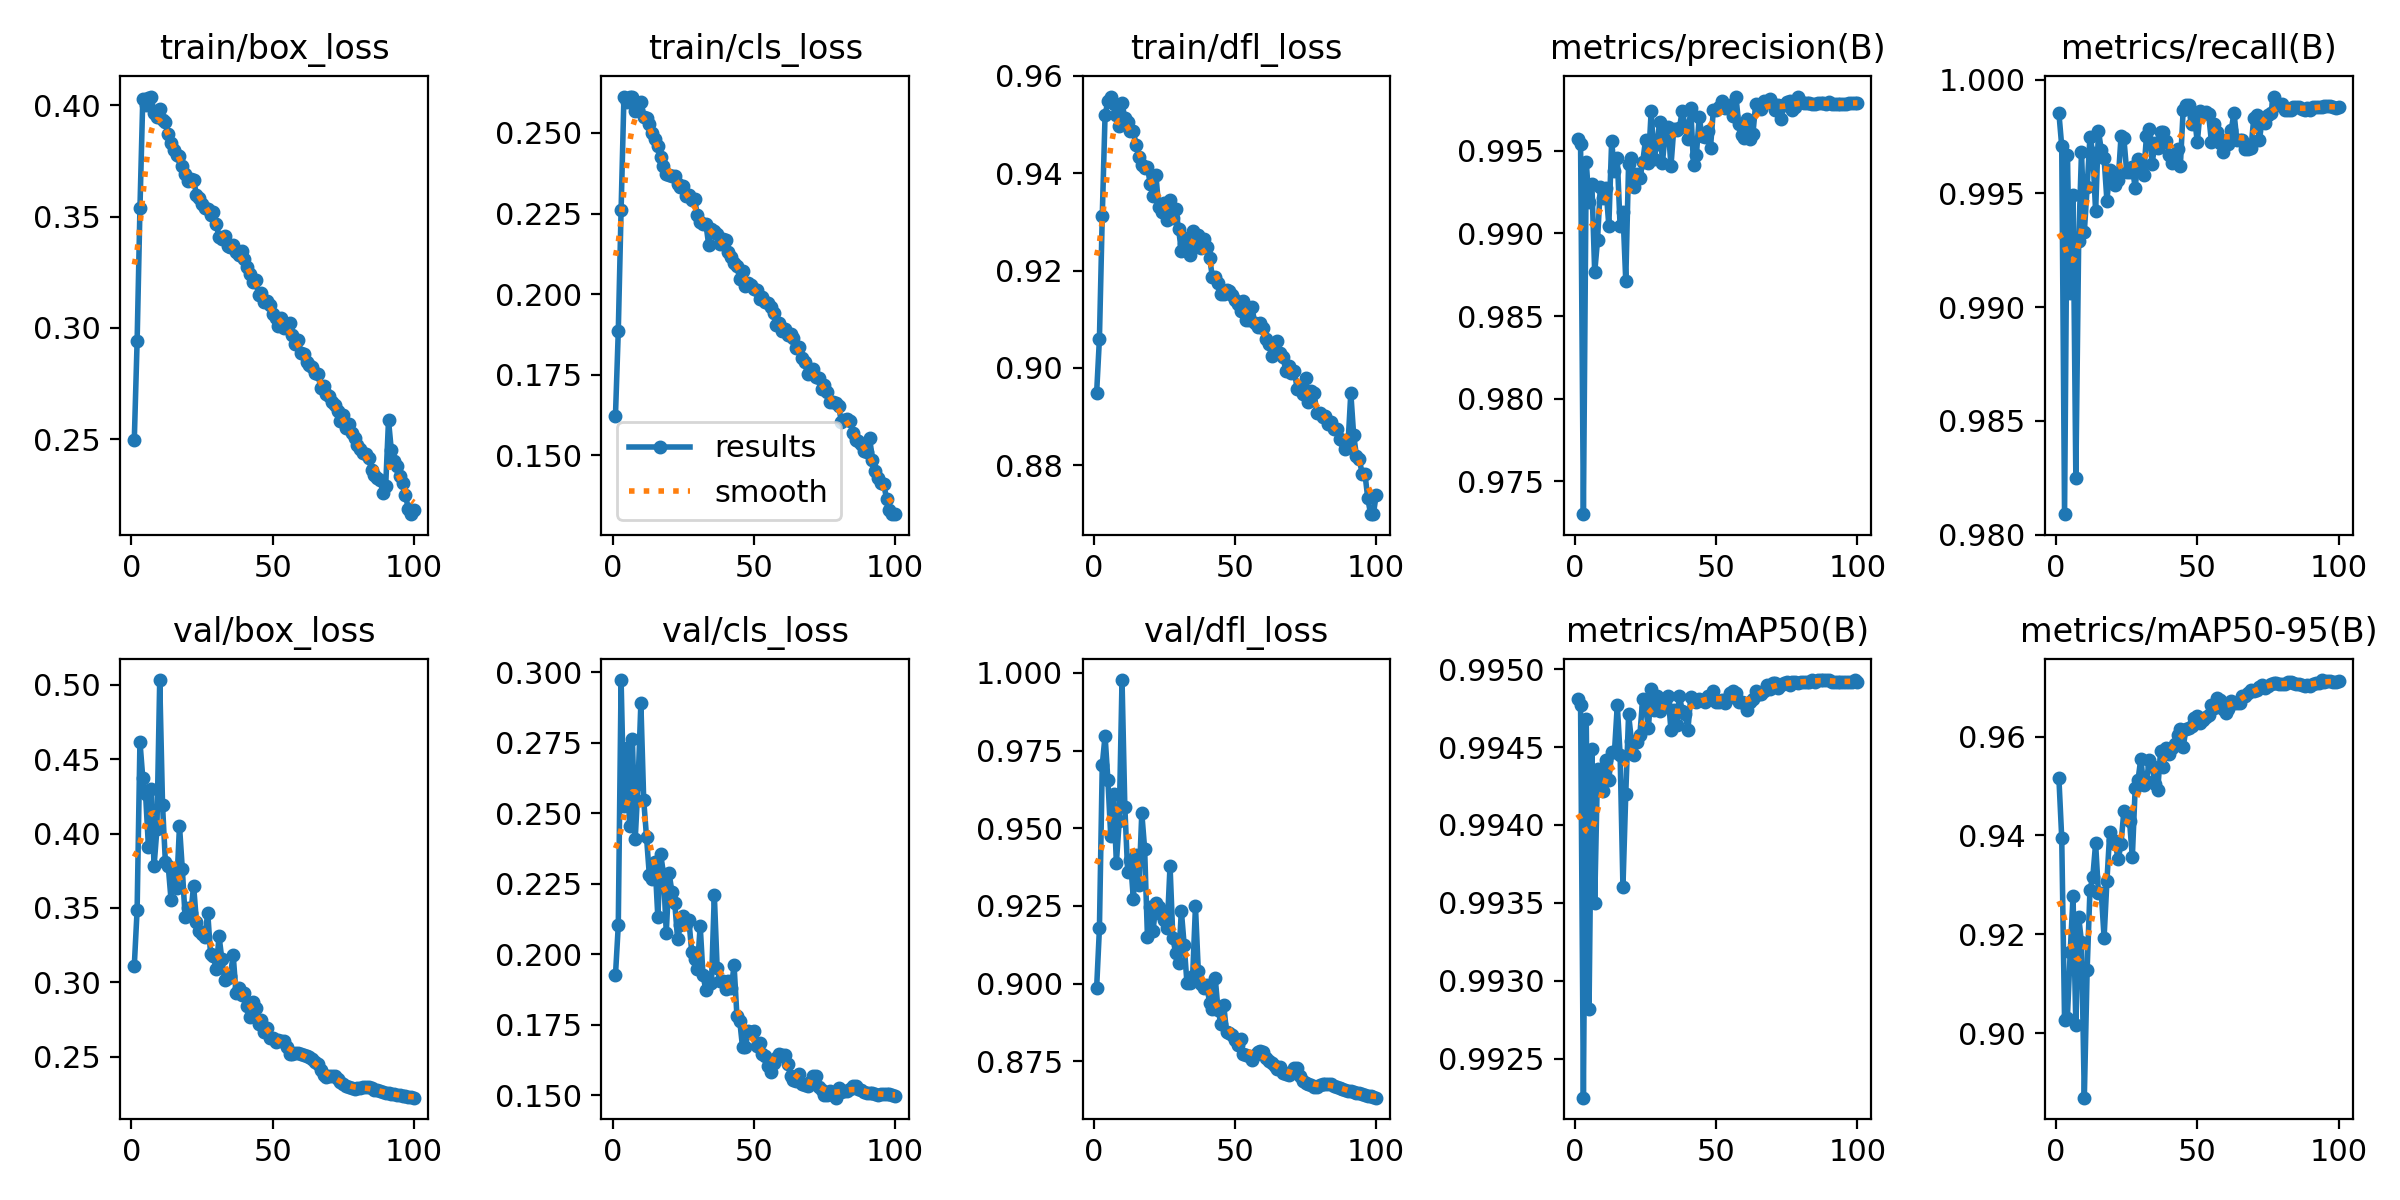

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

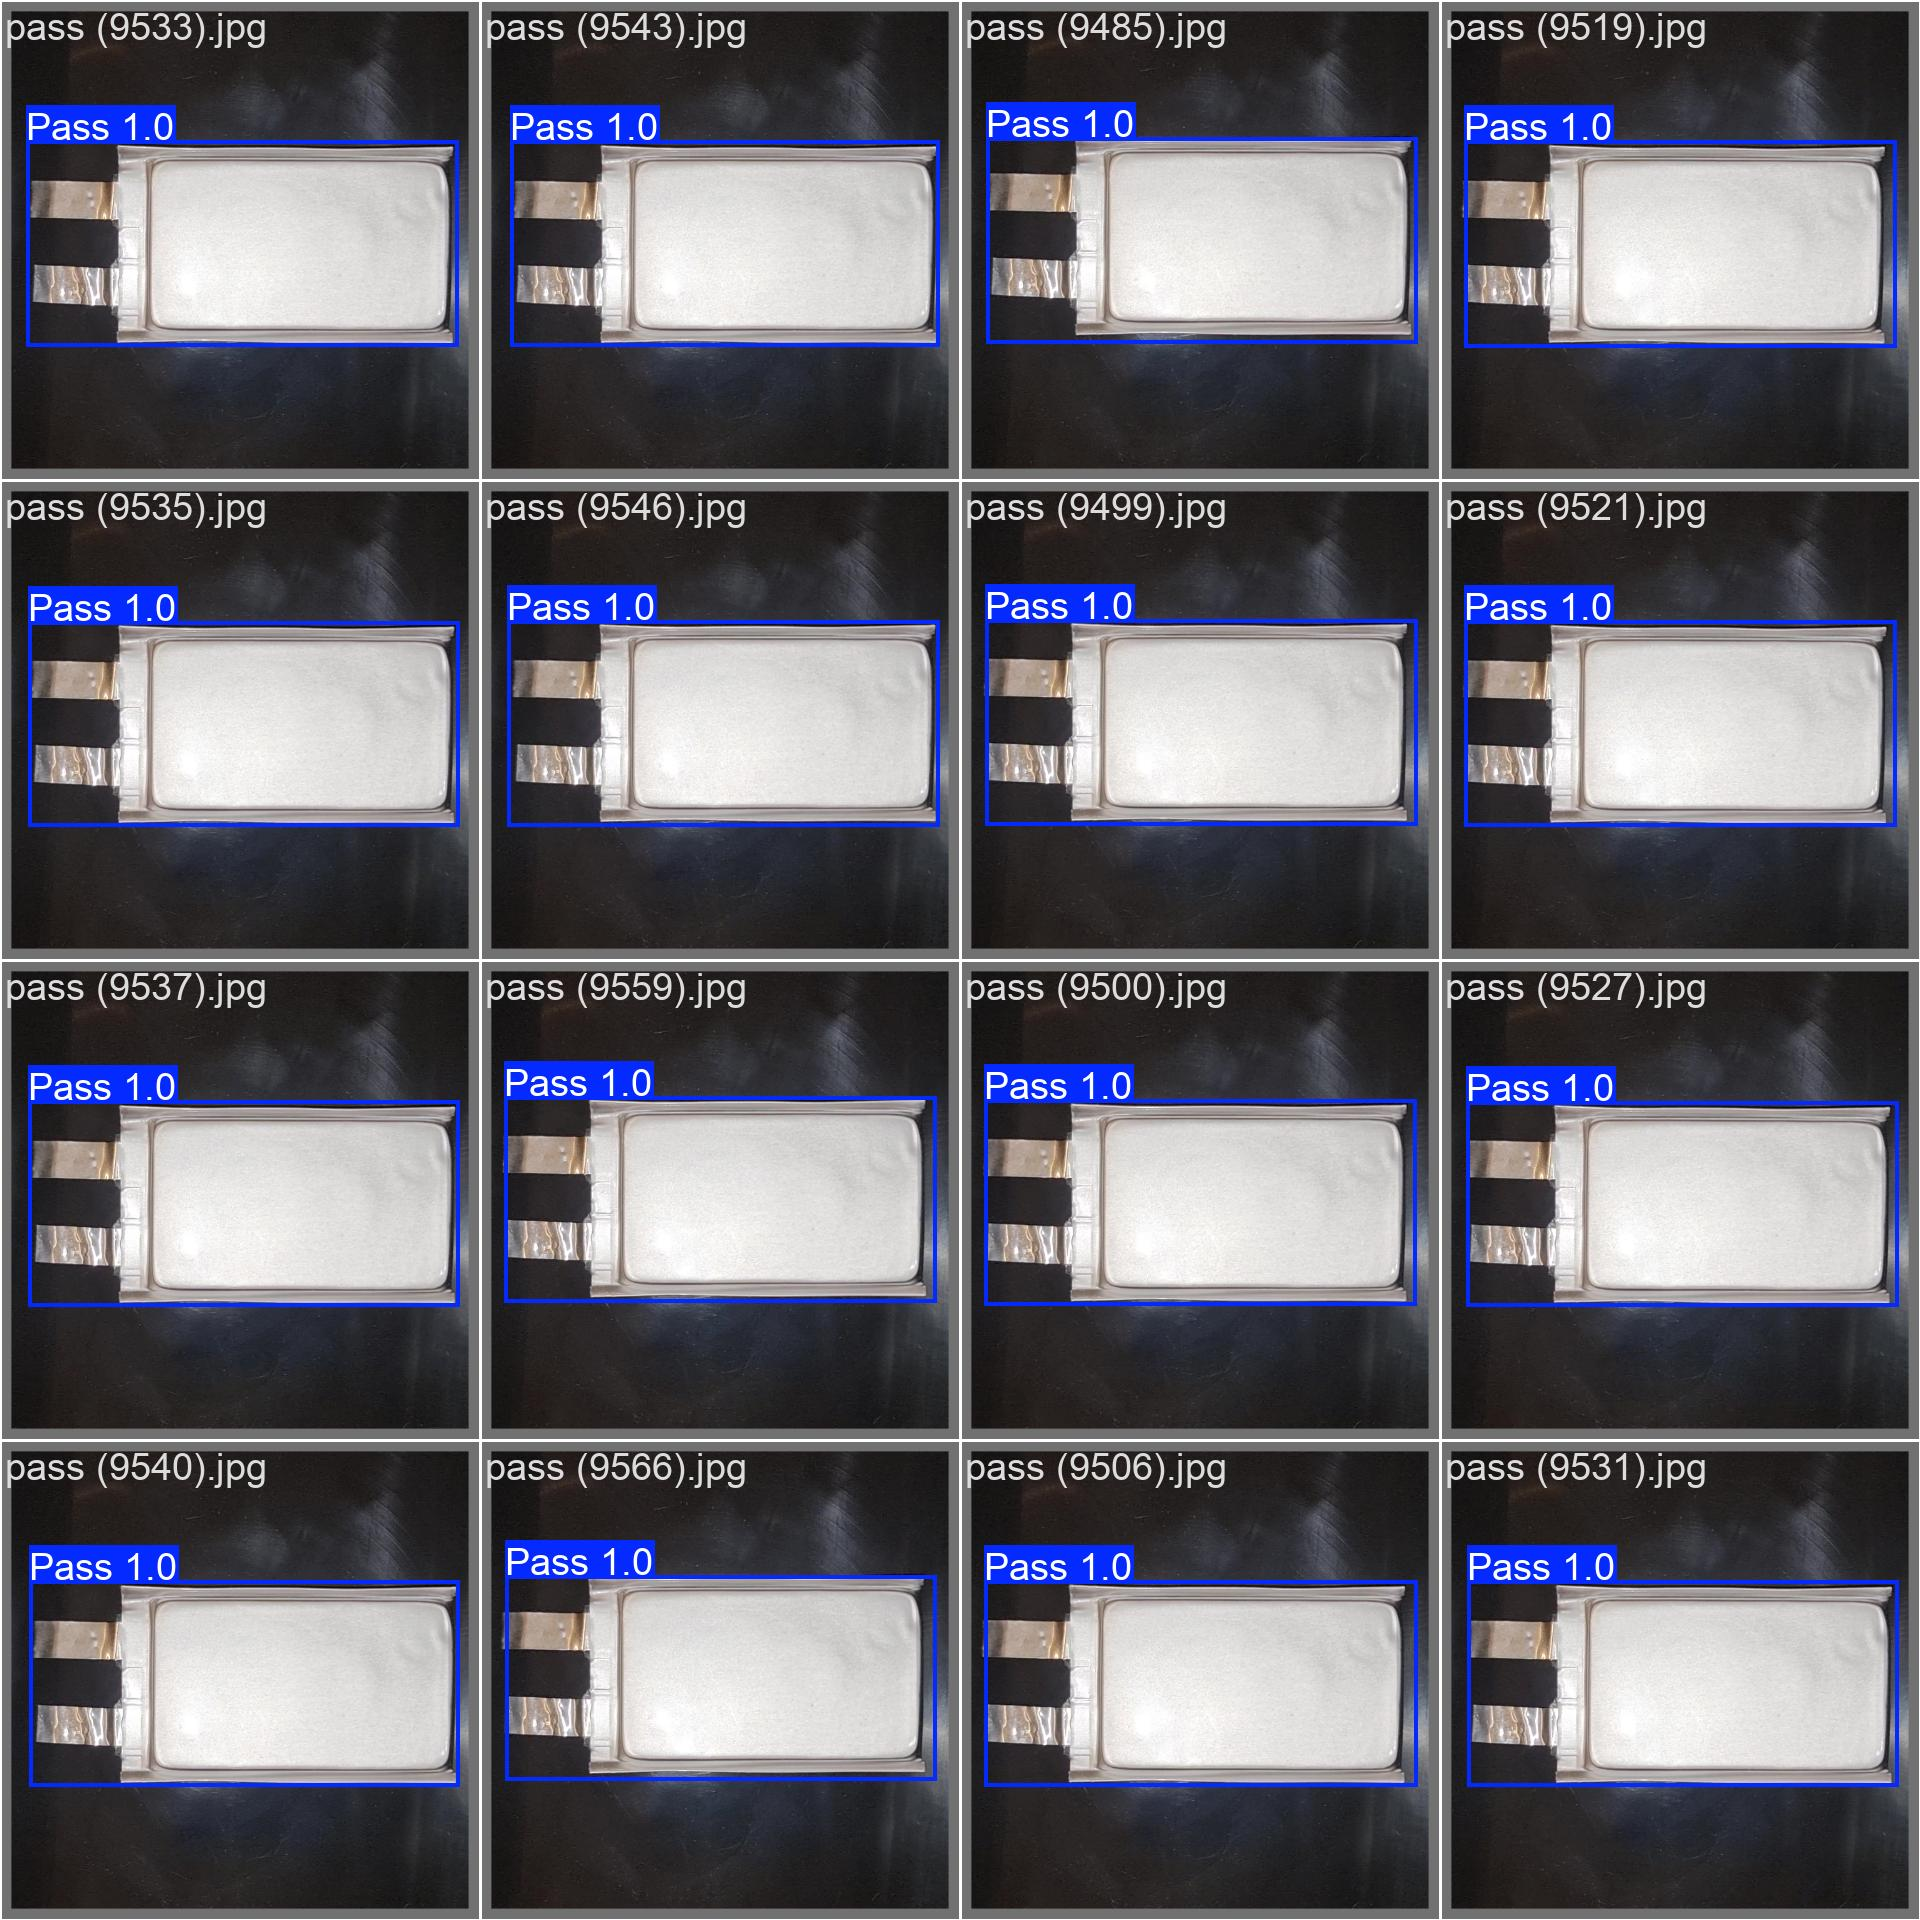

In [ ]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

# **ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ 준비된 코드는 여기 까지 입니다 하기 내용은
# 개인적으로 스터디 중인 부분임 ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ**

In [ ]:
#@title 데이터 연동 확인 必. {run: 'auto'}
logger = 'Comet' #@param ['Comet', 'TensorBoard']

if logger == 'Comet':
  %pip install -q comet_ml
  import comet_ml; comet_ml.init()
elif logger == 'TensorBoard':
  %load_ext tensorboard
  %tensorboard --logdir .

  #API Key = 5dKvyBL4M1AqGE13J5zeJHVFb

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()


# ***※Validate fine-tuned model***

In [ ]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 958, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 148, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 290, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py", line 1039, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
    

# ***※Inference with custom model***

In [ ]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
             ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/cfg/__init__.py", line 958, in entrypoint
    model = YOLO(model, task=task)
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 148, in __init__
    self._load(model, task=task)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 290, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/nn/tasks.py", line 1039, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
    

In [ ]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

ValueError: max() arg is an empty sequence

> <ipython-input-37-dd402b207aaf>(5)<cell line: 0>()
      3 from IPython.display import Image as IPyImage, display
      4 
----> 5 latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
      6 for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
      7     display(IPyImage(filename=img, width=600))



In [ ]:
!yolo export model=yolo11n.pt format=torchscript

# **[v11 모델 Modify 방안]**
1. YOLO 모델의 기본 구조와 주요 수정 포인트
2. 백본(Backbone), 넥(Neck), 헤드(Head) 각 부분 수정 방법
3. 커스텀 레이어 추가 및 설계 방법

# **1. 기본 구조 이해**
```python
# models/yolo.py
class YOLOv11(nn.Module):
    def __init__(self, nc=80, anchors=None):  # nc: 클래스 수
        super().__init__()
        
        # 1. Backbone
        self.backbone = nn.ModuleList([
            # 백본 레이어들
        ])
        
        # 2. Neck (FPN/PAN)
        self.neck = nn.ModuleList([
            # 넥 레이어들
        ])
        
        # 3. Head
        self.head = nn.ModuleList([
            # 디텍션 헤드
        ])
```

# **2. 백본(Backbone) 수정**
```python
# 커스텀 백본 생성
class CustomBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        
        # CSP 레이어 수정 예시
        self.conv1 = Conv(3, 32, 6, 2, 2)  # 커널 크기와 stride 수정
        
        # 블록 추가
        self.block1 = nn.Sequential(
            Conv(32, 64, 3),
            ResBlock(64),
            CBAM(64)  # 어텐션 메커니즘 추가
        )
        
        # 깊이별 컨볼루션 추가
        self.dwconv = nn.Sequential(
            Conv(64, 64, k=3, g=64),  # depthwise
            Conv(64, 128, k=1)        # pointwise
        )

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.block1(x1)
        x3 = self.dwconv(x2)
        return [x1, x2, x3]  # 다중 스케일 피처맵 반환
```

# **3. 넥(Neck) 구조 수정**
```python
class CustomNeck(nn.Module):
    def __init__(self):
        super().__init__()
        
        # FPN (상향식 경로)
        self.up_conv1 = Conv(512, 256, 1)
        self.up_conv2 = Conv(256, 128, 1)
        
        # PAN (하향식 경로)
        self.down_conv1 = Conv(128, 256, 3, s=2)
        self.down_conv2 = Conv(256, 512, 3, s=2)
        
        # 크로스 커넥션 추가
        self.cross_conv = Conv(256, 256, 1)
        
        # 어텐션 메커니즘
        self.cbam = CBAM(256)

    def forward(self, x):
        # FPN
        p5 = self.up_conv1(x[2])
        p4 = self.up_conv2(p5)
        
        # 어텐션 적용
        p4 = self.cbam(p4)
        
        # PAN
        n4 = self.down_conv1(p4)
        n5 = self.down_conv2(n4)
        
        return [p4, n4, n5]
```

# **4. 헤드(Head) 수정**
```python
class CustomHead(nn.Module):
    def __init__(self, nc=80, anchors=3):
        super().__init__()
        
        # 디텍션 헤드 수정
        self.detect = nn.ModuleList()
        for in_channels in [128, 256, 512]:
            self.detect.append(nn.Sequential(
                Conv(in_channels, in_channels, 3),
                Conv(in_channels, anchors * (5 + nc), 1),
                nn.Reshape((-1, 5 + nc))
            ))
        
        # 추가 분류 브랜치
        self.cls_branch = nn.Sequential(
            Conv(512, 256, 1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, nc)
        )

    def forward(self, x):
        detect_out = []
        for i, det in enumerate(self.detect):
            detect_out.append(det(x[i]))
            
        cls_out = self.cls_branch(x[-1])
        return detect_out, cls_out
```

# **5. 커스텀 레이어 예시**
```python
# 새로운 어텐션 메커니즘
class CBAM(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channel_att = ChannelAttention(channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = self.channel_att(x)
        x = self.spatial_att(x)
        return x

# 새로운 블록 디자인
class CustomBlock(nn.Module):
    def __init__(self, c1, c2):
        super().__init__()
        self.conv1 = Conv(c1, c2, 1)
        self.conv2 = Conv(c2, c2, 3)
        self.attention = CBAM(c2)
        self.shortcut = c1 == c2

    def forward(self, x):
        return x + self.attention(self.conv2(self.conv1(x))) if self.shortcut else self.attention(self.conv2(self.conv1(x)))
```

# **6. 전체 모델 통합**
```python
class ModifiedYOLOv11(nn.Module):
    def __init__(self, nc=80):
        super().__init__()
        
        self.backbone = CustomBackbone()
        self.neck = CustomNeck()
        self.head = CustomHead(nc=nc)
        
        # 모델 초기화
        self._initialize_weights()
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        return self.head(x)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
```

주의사항:
1. 메모리 효율성 고려
- 배치 정규화 위치
- 활성화 함수 선택
- 스킵 커넥션 설계

2. 연산량 관리
```python
from thop import profile
model = ModifiedYOLOv11()
input = torch.randn(1, 3, 640, 640)
flops, params = profile(model, inputs=(input, ))
print(f'FLOPs: {flops/1e9:.2f}G, Parameters: {params/1e6:.2f}M')
```

3. 그래디언트 흐름
- 깊이 있는 네트워크의 경우 ResNet 스타일의 잔차 연결 고려
- 그래디언트 체킹을 통한 학습 안정성 확인

추가 팁:
- 모델 수정 전후 성능 비교를 위한 벤치마크 준비
- 점진적인 변경으로 안정성 확보
- 각 레이어의 출력 shape 모니터링

Class 변경으로 구글 드라이브 텍스트 파일 내용 일괄 변경

기존 2,3 삭제 기존 0, 1, 2, 3, 4, 5, 6 ☞ 0, 1, 2, 3, 4

4, 5, 6 ▶ 2, 3, 4

In [ ]:
import os

def update_labels(file_path):
    class_mapping = {
        'Pass': 0,
        'Leakage': 1,
        'Pinhole': 2,
        'Swelling': 3,
        'Scratch': 4
    }

    with open(file_path, 'r') as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if len(parts) > 0:
            class_name = parts[0]
            if class_name in class_mapping:
                new_class_id = class_mapping[class_name]
                parts[0] = str(new_class_id)
                new_lines.append(' '.join(parts) + '\n')

    with open(file_path, 'w') as f:
        f.writelines(new_lines)

# 라벨 파일이 있는 디렉토리 경로
label_dir = '/content/gdrive/MyDrive/PouchCellDefectDetection/DataSet'

for filename in os.listdir(label_dir):
    if filename.endswith('.txt'):
        file_path = os.path.join(label_dir, filename)
        update_labels(file_path)

# **경량화 코드 설명 주석**

In [ ]:
# PyTorch 딥러닝 라이브러리를 불러옵니다.
import torch
# 자동 혼합 정밀도(AMP) 기능을 제공하는 모듈을 amp라는 이름으로 불러옵니다. (cuda.amp 대신 amp 사용)
import torch.amp as amp
# 모델 직렬화(저장/불러오기) 시 안전하게 글로벌 객체를 처리하기 위한 함수를 불러옵니다.
from torch.serialization import safe_globals
# 운영체제와 상호작용하기 위한 기본 모듈 os를 불러옵니다.
import os
# Ultralytics 라이브러리에서 YOLO 객체 검출 모델을 불러옵니다.
from ultralytics import YOLO
# Ultralytics 라이브러리 내의 객체 검출 작업을 위한 DetectionModel 클래스를 불러옵니다.
from ultralytics.nn.tasks import DetectionModel
# 가비지 컬렉션(메모리 관리)을 위한 모듈을 불러옵니다.
import gc

# ModelLightweight 클래스는 모델 경량화(최적화) 작업을 수행하는 도구입니다.
class ModelLightweight:
    # 생성자: 모델 파일의 경로를 받아 초기 설정을 수행합니다.
    def __init__(self, model_path):
        self.model_path = model_path  # 모델 파일 경로를 인스턴스 변수에 저장합니다.
        self.model = None  # 로드된 모델을 저장할 변수, 초기에는 None으로 설정합니다.
        # CUDA가 사용 가능한 경우 'cuda', 그렇지 않으면 'cpu'를 사용하여 디바이스를 설정합니다.
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # 혼합 정밀도 학습을 위한 GradScaler를 CUDA 환경에서 초기화합니다.
        self.scaler = amp.GradScaler('cuda')  # 수정된 GradScaler 초기화

    # A100 GPU 최적화를 위한 CUDA 설정을 수행하는 메소드입니다.
    def setup_cuda(self):
        """A100 GPU 최적화 설정"""
        # CUDA가 사용 가능한지 확인합니다.
        if torch.cuda.is_available():
            # 행렬 곱셈 연산 시 TF32 허용 설정으로 연산 속도를 향상시킵니다.
            torch.backends.cuda.matmul.allow_tf32 = True
            # cudnn 벤치마크 모드를 활성화하여 최적의 알고리즘을 자동 선택하도록 합니다.
            torch.backends.cudnn.benchmark = True
            # 결과의 재현성보다 속도를 우선하기 위해 결정론적 모드를 비활성화합니다.
            torch.backends.cudnn.deterministic = False
            # cudnn에서도 TF32 사용을 허용합니다.
            torch.backends.cudnn.allow_tf32 = True

            # GPU 메모리 캐시를 비워 불필요한 메모리를 해제합니다.
            torch.cuda.empty_cache()
            # 가비지 컬렉터를 실행하여 메모리에서 사용하지 않는 객체를 제거합니다.
            gc.collect()

            # 현재 사용 중인 GPU의 이름을 출력합니다.
            print(f"CUDA 설정 완료: {torch.cuda.get_device_name()}")
            # GPU의 총 메모리 용량(GB 단위)을 출력합니다.
            print(f"Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # 지정된 경로에서 모델을 불러오는 메소드입니다.
    def load_model(self):
        try:
            # 먼저 CUDA 관련 최적화 설정을 적용합니다.
            self.setup_cuda()

            # DetectionModel을 안전하게 처리하기 위한 글로벌 객체 설정을 합니다.
            with safe_globals([DetectionModel]):
                # CUDA 환경에서 자동 혼합 정밀도(autocast)를 적용하여 모델을 로드합니다.
                with amp.autocast('cuda'):  # 수정된 autocast 사용
                    self.model = torch.load(
                        self.model_path,           # 불러올 모델 파일의 경로
                        map_location=self.device,  # 모델을 설정한 디바이스로 로드합니다.
                        weights_only=False         # 모델 가중치 외의 다른 정보도 함께 로드합니다.
                    )
            # 모델 로드가 성공했음을 출력합니다.
            print("모델 로드 성공")
            # 로드된 모델의 타입을 출력하여 확인합니다.
            print(f"모델 타입: {type(self.model)}")  # 디버깅을 위한 모델 타입 출력
            return True  # 성공 시 True 반환
        except Exception as e:
            # 모델 로드 중 예외 발생 시 에러 메시지를 출력합니다.
            print(f"모델 로드 실패: {str(e)}")
            return False  # 실패 시 False 반환

    # 모델의 가중치를 경량화하는 작업(프루닝 및 FP16 변환)을 수행하는 메소드입니다.
    def apply_lightweight_modifications(self):
        try:
            # CUDA 환경에서 자동 혼합 정밀도 모드로 연산합니다.
            with amp.autocast('cuda'):
                # 모델의 구조에 따라 state_dict를 가져옵니다.
                if isinstance(self.model, dict):
                    model_dict = self.model  # 모델이 딕셔너리 형태인 경우 그대로 사용
                elif hasattr(self.model, 'model') and hasattr(self.model.model, 'state_dict'):
                    model_dict = self.model.model.state_dict()  # 내부에 model 속성이 있는 경우 해당 state_dict 사용
                elif hasattr(self.model, 'state_dict'):
                    model_dict = self.model.state_dict()  # 일반적으로 state_dict 메소드를 지원하는 경우 사용
                else:
                    # 지원하지 않는 모델 형식일 경우 메시지를 출력하고 False 반환합니다.
                    print("지원되지 않는 모델 형식입니다.")
                    print(f"모델 타입: {type(self.model)}")
                    return False

                new_state_dict = {}  # 수정된 가중치를 저장할 빈 딕셔너리를 생성합니다.

                # 모델의 각 항목(가중치 등)을 순회합니다.
                for key, value in model_dict.items():
                    # 값이 텐서인 경우에만 경량화 작업을 수행합니다.
                    if isinstance(value, torch.Tensor):
                        # 텐서를 현재 사용 중인 디바이스(GPU 또는 CPU)로 이동합니다.
                        value = value.to(self.device)

                        # 'weight'라는 이름이 포함된 항목에 대해 가중치 프루닝을 수행합니다.
                        if 'weight' in key:
                            threshold = 1e-2  # 프루닝 임계값 설정
                            mask = torch.abs(value) > threshold  # 임계값보다 큰 값만 남기는 마스크 생성
                            value = value * mask  # 마스크를 적용하여 작은 값들을 0으로 만듭니다.

                        # Mixed Precision 학습을 위해 텐서를 FP16(반정밀도)로 변환합니다.
                        value = value.half()

                    # 수정된 값을 새로운 state dictionary에 저장합니다.
                    new_state_dict[key] = value

                # 경량화 작업이 완료된 새로운 state dictionary를 모델로 재할당합니다.
                self.model = new_state_dict
                print("경량화 수정 완료")
                return True  # 성공 시 True 반환

        except Exception as e:
            # 경량화 작업 중 예외 발생 시 에러 메시지와 모델 타입을 출력합니다.
            print(f"경량화 수정 중 에러 발생: {str(e)}")
            print(f"모델 구조: {type(self.model)}")  # 디버깅을 위한 모델 구조 출력
            return False  # 실패 시 False 반환

    # 경량화된 모델을 파일로 저장하는 메소드입니다.
    def save_model(self, output_path):
        try:
            # CUDA 환경에서 자동 혼합 정밀도 모드로 저장 작업을 수행합니다.
            with amp.autocast('cuda'):
                # 지정된 경로에 모델을 저장합니다.
                torch.save(self.model, output_path)
            # 저장 성공 메시지를 출력합니다.
            print(f"모델 저장 완료: {output_path}")
            return True  # 성공 시 True 반환
        except Exception as e:
            # 저장 중 예외 발생 시 에러 메시지를 출력합니다.
            print(f"모델 저장 실패: {str(e)}")
            return False  # 실패 시 False 반환

# 모델의 구조를 분석하여 정보를 출력하는 함수입니다.
def analyze_model_structure(model):
    """모델 구조 분석"""
    # 분석 시작 메시지를 출력합니다.
    print("\n=== 모델 구조 분석 ===")
    if isinstance(model, dict):
        # 모델이 딕셔너리 형태인 경우, 각 키(key)를 출력합니다.
        print("Dictionary 형태의 모델")
        for key in model.keys():
            print(f"키: {key}")
    elif hasattr(model, 'model'):
        # 모델이 내부에 model 속성을 가지고 있는 경우, 해당 구조를 출력합니다.
        print("내부 모델 구조 있음")
        print(model.model)
    else:
        # 위의 조건에 해당하지 않는 경우 모델의 타입과 가능한 속성을 출력합니다.
        print(f"모델 타입: {type(model)}")
        print(dir(model))

# 주어진 모델 파일을 로드하여 검증하는 함수입니다.
def verify_model(model_path, device):
    """모델 검증"""
    try:
        # DetectionModel을 안전하게 불러오기 위한 설정을 합니다.
        with safe_globals([DetectionModel]):
            # 자동 혼합 정밀도 모드로 모델을 로드합니다.
            with amp.autocast('cuda'):
                model = torch.load(model_path, map_location=device, weights_only=False)

        # 모델 검증 시작 메시지를 출력합니다. (파일 이름만 출력)
        print(f"\n=== 모델 검증: {os.path.basename(model_path)} ===")
        # 모델의 구조를 분석하는 함수를 호출합니다.
        analyze_model_structure(model)

        # CUDA 사용 시, GPU의 현재 메모리 사용량과 캐시 정보를 출력합니다.
        if torch.cuda.is_available():
            print(f"\nGPU 메모리 사용량: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
            print(f"GPU 메모리 캐시: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

        return True  # 검증 성공 시 True 반환
    except Exception as e:
        # 검증 중 예외 발생 시 에러 메시지를 출력합니다.
        print(f"모델 검증 실패: {str(e)}")
        return False  # 실패 시 False 반환

# 메인 함수: 전체 경량화 프로세스의 흐름을 제어합니다.
def main():
    # 경량화 작업 시작 메시지를 출력합니다.
    print("YOLOv11n 모델 경량화 시작")

    # 사용 가능한 디바이스(GPU 또는 CPU)를 설정합니다.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # CUDA가 사용 가능하면 GPU 관련 정보를 출력합니다.
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name()}")
        print(f"CUDA 버전: {torch.version.cuda}")
        print(f"PyTorch 버전: {torch.__version__}")

    # 원본 모델 파일과 경량화된 모델 파일의 경로를 설정합니다.
    model_path = '/content/gdrive/MyDrive/PouchCellDefectDetection/yolov11nbest.pt'
    output_path = '/content/yolov11n_lightweight.pt'

    # ModelLightweight 클래스의 인스턴스를 생성하여 모델 경량화 작업을 준비합니다.
    lightweight = ModelLightweight(model_path)

    # 모델을 불러오고, 로드에 실패하면 프로그램을 종료합니다.
    if not lightweight.load_model():
        return

    # 불러온 모델의 구조를 분석하여 출력합니다.
    analyze_model_structure(lightweight.model)

    # 경량화(수정) 작업을 수행하고, 실패하면 프로그램을 종료합니다.
    if not lightweight.apply_lightweight_modifications():
        return

    # 경량화된 모델을 저장하고, 실패하면 프로그램을 종료합니다.
    if not lightweight.save_model(output_path):
        return

    # 원본 모델과 경량화된 모델의 파일 크기를 MB 단위로 계산합니다.
    original_size = os.path.getsize(model_path) / (1024 * 1024)
    modified_size = os.path.getsize(output_path) / (1024 * 1024)

    # 경량화 결과(파일 크기 및 감소율)를 출력합니다.
    print("\n=== 모델 경량화 결과 ===")
    print(f"원본 모델 크기: {original_size:.2f} MB")
    print(f"수정된 모델 크기: {modified_size:.2f} MB")
    print(f"크기 감소율: {((original_size - modified_size) / original_size * 100):.2f}%")

    # 원본 모델을 검증하는 함수를 호출합니다.
    print("\n원본 모델 검증")
    verify_model(model_path, device)

    # 경량화된 모델을 검증하는 함수를 호출합니다.
    print("\n경량화된 모델 검증")
    verify_model(output_path, device)

    # 작업 종료 후 GPU 메모리 캐시를 비우고 가비지 컬렉션을 실행하여 메모리를 정리합니다.
    torch.cuda.empty_cache()
    gc.collect()

# 이 스크립트가 메인 프로그램으로 실행될 때 main() 함수를 호출합니다.
if __name__ == "__main__":
    # 시작 메시지를 출력합니다. (YOLOv11n 모델 경량화 도구와 A100 최적화 대상)
    print("\n=== YOLOv11n 모델 경량화 도구 (A100 최적화) ===")
    main()
